# ERT simulation

In [16]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

### Define geometry

In [17]:
world = mt.createWorld(start=[0, 0], end=[39, -10], 
                       worldMarker=True)

xz = np.load('models/boundary.npy')

line = mt.createPolygon(xz, marker=1)

geom = world + line

(<Axes: >, None)

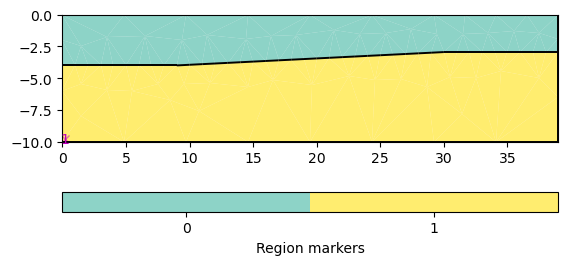

In [18]:
pg.show(geom)

In [19]:
scheme = ert.createData(elecs=np.linspace(start=0, stop=36, num=72, endpoint=False),
                           schemeName='dd')

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fcae693f4d0>)

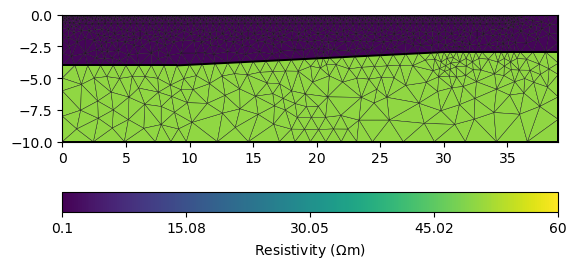

In [20]:
for p in scheme.sensors():
    geom.createNode(p)
    geom.createNode(p - [0, 0.1])

# Create a mesh for the finite element modelling with appropriate mesh quality.
mesh = mt.createMesh(geom, quality=34)

# Create a map to set resistivity values in the appropriate regions
# [[regionNumber, resistivity], [regionNumber, resistivity], [...]
rhomap = [[0, 0.83],
          [1, 50],]

# Take a look at the mesh and the resistivity distribution
pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True, cMin=0.1, cMax=60, cMap='viridis',
       norm='log')

### Simulate data

In [21]:
data = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

ModellingBase::setMesh() copying new mesh ... Found datafile: 72 electrodes
Found: 72 free-electrodes
rMin = 0.25, rMax = 71
NGauLeg + NGauLag for inverse Fouriertransformation: 14 + 4
Found non-Neumann domain
0.0252522 s
FOP updating mesh dependencies ... 6.4e-06 s


20/04/24 - 22:05:09 - pyGIMLi - INFO - Data error estimate (min:max)  0.010011361350564435 : 0.10026422520943638
20/04/24 - 22:05:09 - pyGIMLi - INFO - 1.7783153498370297 104.83473001658018
20/04/24 - 22:05:09 - pyGIMLi - INFO - Simulated data Data: Sensors: 72 data: 2415, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
20/04/24 - 22:05:09 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
20/04/24 - 22:05:09 - pyGIMLi - INFO - Simulated rhoa (min/max) 0.7643748555449476 6.5247879820195855
20/04/24 - 22:05:09 - pyGIMLi - INFO - Selected data noise %(min/max) 1.0011361350564436 10.026422520943639


Calculating response for model: min = 0.83 max = 50
Allocating memory for primary potential...... 0.0163107

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.622698s
Response: min = 0.789129 max = 5.79262 mean = 1.80003
Reciprocity rms(modelReciprocity) 1.41205%, max: 3.91672%
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100


20/04/24 - 22:05:56 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.7643748555449476 6.5247879820195855


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fcae6706c90>)

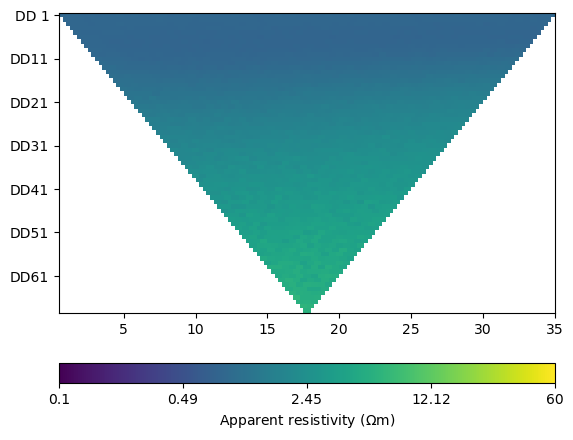

In [25]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('data/ERTLine.dat')

# You can take a look at the data
ert.show(data, cMin=0.1, cMax=60, cMap='viridis')

### Invert 

In [26]:
mgr = ert.ERTManager('data/ERTLine.dat')

In [27]:
inv = mgr.invert(lam=20, verbose=False)
#np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1)

20/04/24 - 22:05:58 - pyGIMLi - INFO - Found 2 regions.
20/04/24 - 22:05:58 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
20/04/24 - 22:05:58 - pyGIMLi - INFO - Found 2 regions.
20/04/24 - 22:05:58 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
20/04/24 - 22:05:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
20/04/24 - 22:05:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
20/04/24 - 22:05:58 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3214 Cells: 6052 Boundaries: 4726
20/04/24 - 22:05:58 - pyGIMLi - INFO - Use median(data values)=1.39774567485903
20/04/24 - 22:05:58 - pyGIMLi - INFO - Created startmodel from forward operator: 1212, min/max=1.397746/1.397746


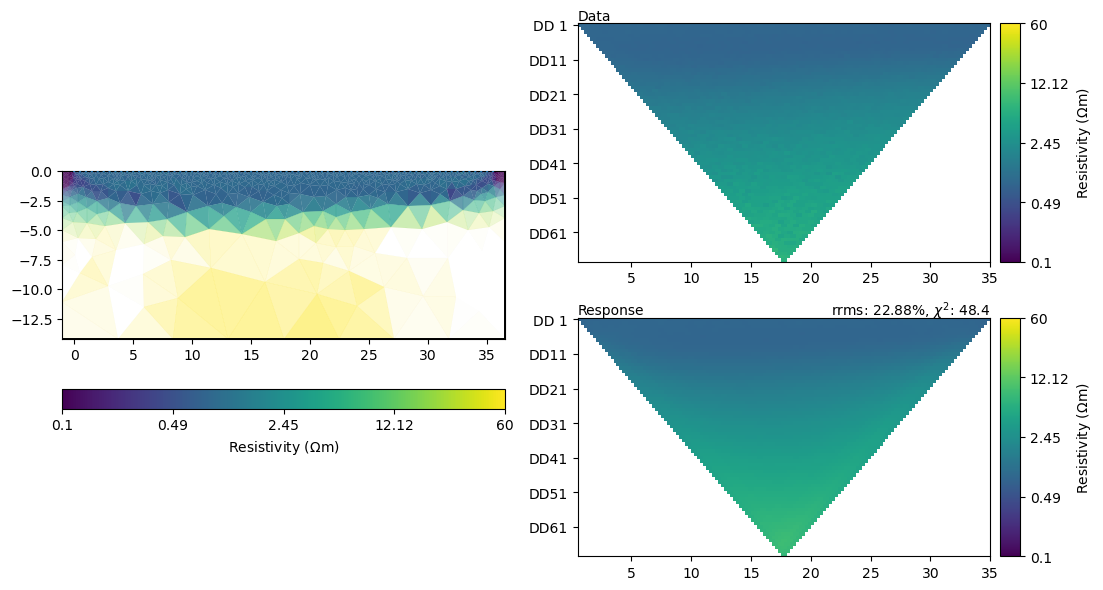

In [28]:
mgr.showResultAndFit(cMin=0.1, cMax=60, cMap='viridis')
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later

(-10.0, 0.0)

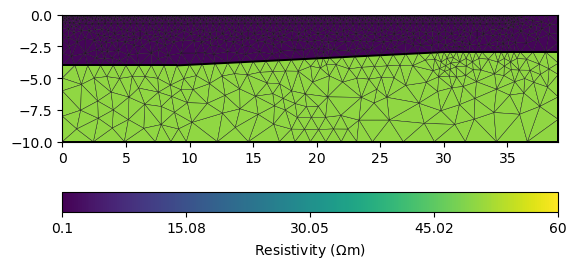

In [29]:
fig, ax = plt.subplots()
pg.show(mesh, data=rhomap, label=pg.unit('res'), 
        showMesh=True, cMin=0.1, cMax=60, cMap='viridis', ax=ax)
ax.set_ylim([-10,0])
#ax.set_xlim([-72,72])

(-10.0, 0.0)

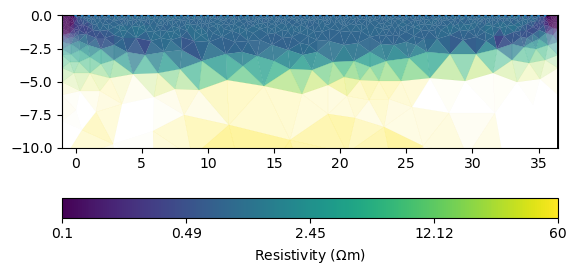

In [30]:
fig, ax = plt.subplots()

mgr.showModel(cMin=0.1, cMax=60, cMap='viridis', elecs=True, ax=ax, zMax=50)
ax.set_ylim([-10,0])


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fcacb7e0fd0>)

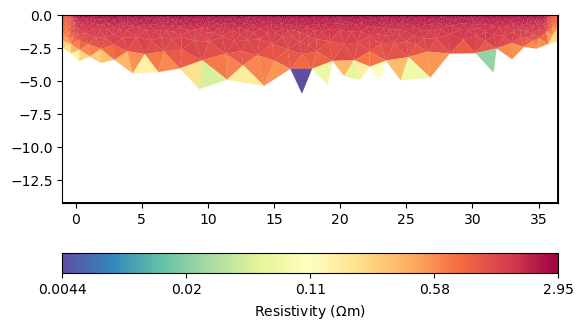

In [31]:
fig, ax = plt.subplots()
mgr.fop.drawModel(ax, mgr.coverage())